In [1]:
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig
import warnings
from random import sample
import timeit
import functools
from scipy.optimize import curve_fit

In [2]:
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Traffic congestion

## Paper 1

In [3]:
class Package:
    def __init__(self, position, destination):
        assert isinstance(position, (int, np.integer)), "AssertionError: wrong position type passed"
        assert isinstance(destination, (int, np.integer)), "AssertionError: wrong destination type passed"
            
        self.pos = position
        self.dst = destination

    def hasArrived(self):
        return self.pos == self.dst
    
    def updatePos(self, new_pos):
        self.pos = new_pos

    def __str__(self):
        return f"pos = {self.pos}, dst = {self.dst}"

In [4]:
def congestionFunc(n, gamma):
    n = n.astype(float)
    return np.where(n > 0, n**(-gamma), 0)

def getCongestionMat(package_distr, gamma, n):
    cong_prob = congestionFunc(package_distr, gamma)
    return np.tile(cong_prob, (n,1)).T

def calcCommMatrix(package_distr, gamma, n): # k matrix in paper
    xi = np.ones((n,n))
    #xi = np.random.rand(n,n)

    cong_mat = getCongestionMat(package_distr, gamma, n)
    k_mat = xi*cong_mat

    return k_mat

def addPackage(pList, package_distr, creation_prob, n):
    r = np.random.rand(n)
    creation_pos = np.where(r < creation_prob)[0]
    rand_ind_dst = np.random.randint(n, size=np.shape(creation_pos))

    # Add new packages
    for i, pos in enumerate(creation_pos):
        newPackage = Package(pos, rand_ind_dst[i])
        pList.append(newPackage)
        
        package_distr[pos] += 1

def removePackages(pList, package_distr):
    for i, o in enumerate(pList):
        if o.hasArrived():
            curr_pos = o.pos
            package_distr[curr_pos] -= 1
            del pList[i]

def makeOnePackage(pList, package_distr):
    newPackage = Package(0, 1)
    pList.append(newPackage)
    
    package_distr[0] += 1

def makeStep(graph, package_distr, package_list, gamma, p):
    n = graph.vcount()
    addPackage(package_list, package_distr, p, n)

    trMat = calcCommMatrix(package_distr, gamma, n)
    adj = np.array(graph.get_adjacency().data)
    trMat = (adj@trMat).T
    rand_mat = np.random.rand(n,n)
    accept_mat = trMat - rand_mat
    for package in package_list:
        package_pos = package.pos

        neighboursTrProb = accept_mat[package_pos]
        if np.any(neighboursTrProb > 0):
            next_pos = np.where(neighboursTrProb == np.max(neighboursTrProb))[0].item()
            package_distr[package.pos] -= 1
            package_distr[next_pos] += 1
            package.updatePos(next_pos)
    
    removePackages(package_list, package_distr)
    
    return package_distr

In [6]:
def runSim(p, g, gamma, numSteps=10000, show_progress=True):
    n = g.vcount()

    package_distr = np.zeros(n)
    package_list = []
    pList_evol = np.zeros((numSteps, n))
    
    ctr = 0
    for i in range(numSteps):
        ctr += 1
        if show_progress:
            print(f"{np.round(ctr*100/numSteps, 0)}%", end="\r")
        
        package_distr = makeStep(g, package_distr, package_list, gamma, p)
        pList_evol[i] += package_distr.copy()
    
    return pList_evol

def runTree_Sim_series(p, z, m, gamma, numSteps=10000, iterations=10, show_progress=True):
    """
    p = creation probability
    z = branching factor
    m = nr of levels
    """

    n = 0
    for i in range(m):
        n += z**i
    g = ig.Graph.Tree(n, z)
    
    tot_pList_evol = np.zeros((numSteps, n))

    for i in range(iterations):
        if show_progress:
            print(f"Iteration {i+1}/{iterations}")
        pList_evol = runSim(p, g, gamma, numSteps, show_progress)
        tot_pList_evol += pList_evol

    return np.sum(tot_pList_evol, axis=1)/(iterations*g.vcount())

def runER_Sim_series(p, n, edge_prob, gamma, numSteps=10000, iterations=10, show_progress=True):
    
    tot_pList_evol = np.zeros((numSteps, n))

    for i in range(iterations):
        g = ig.Graph.Erdos_Renyi(n, edge_prob, directed=False, loops=False)
        if show_progress:
            print(f"Iteration {i+1}/{iterations}")
        pList_evol = runSim(p, g, gamma, numSteps, show_progress)
        tot_pList_evol += pList_evol

    return tot_pList_evol/iterations

In [7]:
def getTr_prob(graph, package, package_distr, temp, h):
    pos = package.pos
    neighbours = graph.neighbors(pos)
    cost = np.zeros(len(neighbours))
    for i, neighbour_pos in enumerate(neighbours):
        cost[i] = (len(graph.get_shortest_paths(neighbour_pos, package.dst)[0])*h + (1-h)*package_distr[pos])/temp

    if 1/np.sum(np.exp(-cost)) >= np.infty:
        cost = 1 - cost + cost**2 / 2
        return cost/np.sum(cost)

    # Normalize the cost values for numerical stability
    max_cost = np.max(cost)
    #cost = np.exp(-(cost - max_cost))
    
    return np.exp(-cost)/(np.sum(np.exp(-cost)))

def makeStepTwo(graph, package_distr, package_list, pQueue, temp, h):
    n = graph.vcount()
    
    #addPackage(package_list, package_distr, p, n)

    temp_packageStorage = []
    for nodeQueue in pQueue:
        if nodeQueue:
            package = nodeQueue[0]
            trProb = getTr_prob(graph, package, package_distr, temp, h)
            rand_mat = np.random.rand(np.shape(trProb)[0])
            accept_mat = trProb - rand_mat

            neighbour_ind = np.where(accept_mat == np.max(accept_mat))[0]
            if len(neighbour_ind) > 1:
                neighbour_ind = neighbour_ind[np.random.randint(len(neighbour_ind))]
            else:
                if len(neighbour_ind) == 0:
                    print(trProb)
                neighbour_ind = neighbour_ind[0]
            
            next_pos = graph.neighbors(package.pos)[neighbour_ind]
            package_distr[package.pos] -= 1
            package_distr[next_pos] += 1
            package.updatePos(next_pos)
            temp_packageStorage.append(package)
            nodeQueue.pop(0)

    for package in temp_packageStorage:
        pQueue[package.pos].append(package)
    
    removePackages(package_list, package_distr)
    
    return package_distr

def allocate(n,k):
    dividers = sample(range(1, n+k), k-1)
    dividers = sorted(dividers)
    dividers.insert(0, 0)
    dividers.append(n+k)
    return np.array([dividers[i+1]-dividers[i]-1 for i in range(k)])
    
def runSimTwo(numPackages, g, h, temp, numSteps=10000, show_progress=True):
    n = g.vcount()

    package_distr = allocate(numPackages, n)
    pList = []
    pList_evol = np.zeros((numSteps, n))
    rand_ind_dst = np.random.randint(n, size=n)

    # Initialise package queue
    pQueue = np.empty(n, dtype=object)
    for i in range(n):
        pQueue[i] = []

    # Initialise packages
    for pos, num in enumerate(package_distr):
        for _ in range(num):
            newPackage = Package(pos, rand_ind_dst[pos])
            pList.append(newPackage)
            pQueue[pos].append(newPackage)

    ctr = 0
    while(package_distr.any() != 0 and ctr < numSteps):
        package_distr = makeStepTwo(g, package_distr, pList, pQueue, temp, h)
        pList_evol[ctr] += package_distr.copy()

        ctr += 1
        if show_progress:
            print(f"{np.round(ctr*100/numSteps, 0)}%", end="\r")
    
    return pList_evol

In [93]:
numPackages = 10000
n = 1000
m = 2
temp = 1
steps = 10000

g = ig.Graph.Barabasi(n, m, directed=False)
pList_evol = runSimTwo(numPackages, g, 0, temp, steps)
pList_evol2 = runSimTwo(numPackages, g, 0.75, temp, steps)
pList_evol3 = runSimTwo(numPackages, g, 1, temp, steps)

In [94]:
numPackages2 = 1000

pList_evol_ = runSimTwo(numPackages2, g, 0, temp, steps)
pList_evol2_ = runSimTwo(numPackages2, g, 0.75, temp, steps)
pList_evol3_ = runSimTwo(numPackages2, g, 1, temp, steps)

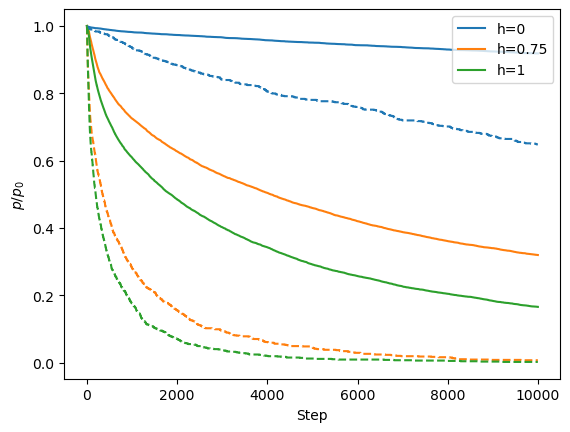

In [96]:
plt.plot(np.arange(steps), np.sum(pList_evol, axis=1)/numPackages)
plt.plot(np.arange(steps), np.sum(pList_evol2, axis=1)/numPackages)
plt.plot(np.arange(steps), np.sum(pList_evol3, axis=1)/numPackages)

plt.plot(np.arange(steps), np.sum(pList_evol_, axis=1)/numPackages2, ls="--", c="tab:blue")
plt.plot(np.arange(steps), np.sum(pList_evol2_, axis=1)/numPackages2, ls="--", c="tab:orange")
plt.plot(np.arange(steps), np.sum(pList_evol3_, axis=1)/numPackages2, ls="--", c="tab:green")

labels = ["h=0", "h=0.75", "h=1"]
plt.xlabel("Step")
plt.ylabel(r"$p/p_0$")
plt.legend(labels, loc="upper right")
plt.show()

In [24]:
z_range = np.arange(1, 8)
m = 4
exec_time = np.zeros(len(z_range))
sys_size = np.zeros(len(z_range))

for i, z in enumerate(z_range):
    t = timeit.timeit(functools.partial(runTree_Sim_series, 0.03, z, m, 2, 10000, 1), number=1)
    exec_time[i] += t

    n = 0
    for j in range(m):
        n += z**j
    sys_size[i] += n

Iteration 1/1
Iteration 1/1
Iteration 1/1
Iteration 1/1
Iteration 1/1
Iteration 1/1
Iteration 1/1


[1.13921962]
[4.04785572]


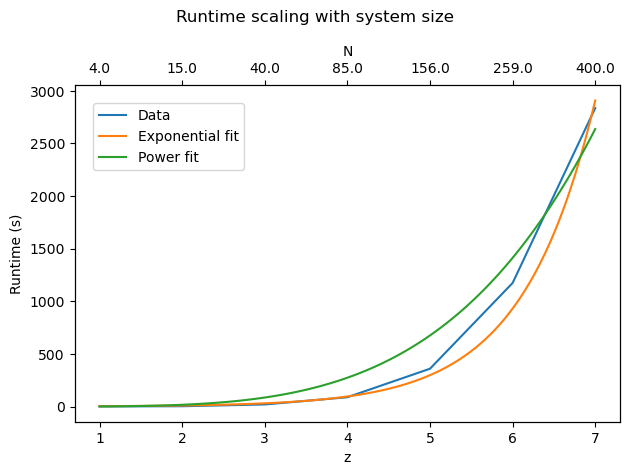

In [66]:
def exp_func(x, a):
    return np.exp(a*x)

def pow_func(x, a):
    return x**a

popt, pcov = curve_fit(exp_func, z_range, exec_time)
popt2, pcov2 = curve_fit(pow_func, z_range, exec_time)
print(popt)
print(popt2)

fig, ax = plt.subplots()

fig.suptitle("Runtime scaling with system size")
ax.plot(z_range, exec_time, label="Data")
ax.plot(np.linspace(z_range[0], z_range[-1], 100), exp_func(np.linspace(z_range[0], z_range[-1], 100), popt), label="Exponential fit")
ax.plot(np.linspace(z_range[0], z_range[-1], 100), pow_func(np.linspace(z_range[0], z_range[-1], 100), popt2), label="Power fit")
ax.set_xlabel("z")
ax.set_ylabel("Runtime (s)")

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(z_range)
ax2.set_xticklabels(sys_size)
ax2.set_xlabel("N")

fig.tight_layout()
fig.legend(bbox_to_anchor=(0.4, 0.8))

plt.show()

In [21]:
p = 0.05
gamma = 2
z = 4
m = 4
n = 0
for i in range(m):
    n += z**i

package_nr_evol = runTree_Sim_series(p, z, m, gamma)
package_nr_evol_ER = runER_Sim_series(p, n, 0.7, gamma)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


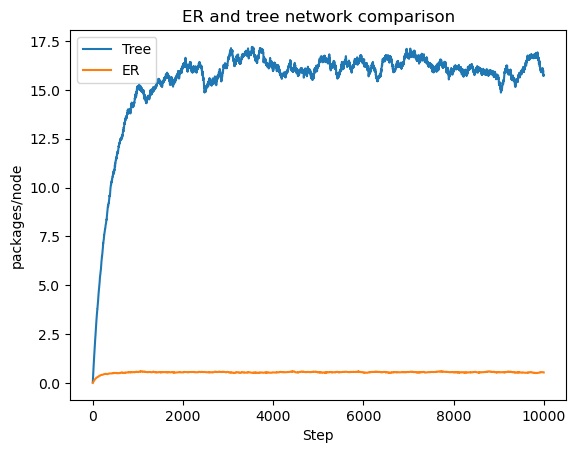

In [28]:
plt.title(f"ER and tree network comparison")
plt.xlabel("Step")
plt.ylabel("packages/node")
plt.plot(np.arange(10000), package_nr_evol, label="Tree")
plt.plot(np.arange(10000), np.sum(package_nr_evol_ER, axis=1)/(10*n), label="ER")
plt.legend()
plt.show()

## Critical behaviour using analytical expression for $p_c$

In [7]:
def calc_pc(z, m):
    return np.sqrt(z)/((z*(z**(m-1) - 1)**2)/(z**m - 1) + 1)

def calc_eta(p, S, delta_N, delta_t):
    return 1/(p*S) * delta_N/delta_t

In [11]:
z = 3
m = 5
gamma = 0.5
steps = 10000
lower = 1500
delta_t = 500

pc = calc_pc(z,m)
Nc = z**(3/2)/(z-1)
s = Nc/pc

p_range = np.linspace(pc/10, pc*2, num=15)
etas = np.zeros(len(p_range))

for i, p in enumerate(p_range):
    print(f"Running for p = {p}")
    package_nr_evol = runTree_Sim_series(p, z, m, 0.5)

    totPackNr_evolution = np.zeros(steps)
    for j, pList in enumerate(package_nr_evol):
        totPackNr_evolution[j] += np.sum(pList)

    av_delta_N = 0
    prev = lower-1
    for j in range(steps)[lower+delta_t-1::delta_t]:
        av_delta_N += abs(totPackNr_evolution[j] - totPackNr_evolution[prev])
        prev = j

    av_delta_N /= ((steps-lower)/delta_t + 1)
    etas[i] += calc_eta(p, s, av_delta_N, delta_t)

Running for p = 0.002155931979383131
Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
Running for p = 0.005081839665688808
Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
Running for p = 0.008007747351994485
Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
Running for p = 0.010933655038300162
Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
Running for p = 0.01385956272460584
Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
Running for p = 0.016785470410911517
Iteration 1/10
Iteration

0.021559319793831307


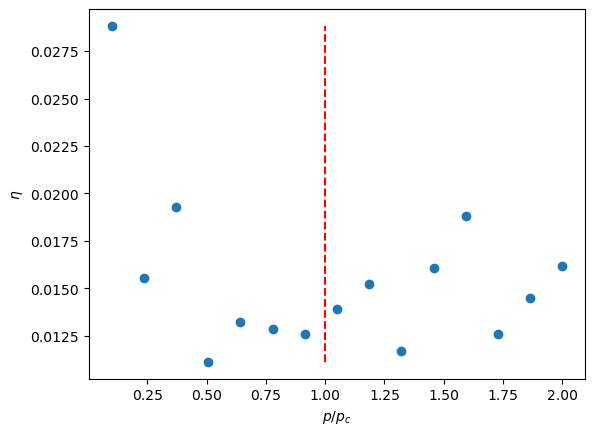

In [12]:
print(pc)
plt.scatter(p_range/pc, etas)
plt.vlines(1, np.min(etas), np.max(etas), color='r', ls='--')
plt.xlabel(r'$p/p_c$')
plt.ylabel(r'$\eta$')
plt.show()